In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import holidays
import requests
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('../scripts')))
from plots import *

In [3]:
completed_df = pd.read_csv('../data/rawdata/nb.csv')
df = pd.read_csv('../data/rawdata/driver_locations_during_request.csv')

In [4]:
completed_df.columns

Index(['Trip ID', 'Trip Origin', 'Trip Destination', 'Trip Start Time',
       'Trip End Time'],
      dtype='object')

In [5]:
completed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536020 entries, 0 to 536019
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Trip ID           536020 non-null  int64 
 1   Trip Origin       536020 non-null  object
 2   Trip Destination  536020 non-null  object
 3   Trip Start Time   534369 non-null  object
 4   Trip End Time     536019 non-null  object
dtypes: int64(1), object(4)
memory usage: 20.4+ MB


In [6]:
df.columns

Index(['id', 'order_id', 'driver_id', 'driver_action', 'lat', 'lng',
       'created_at', 'updated_at'],
      dtype='object')

In [7]:
df = df.drop(['updated_at', 'created_at'], axis=1)

Feature Extraction

In [8]:
# Convert timestamp to datetime
completed_df['datetime'] = pd.to_datetime(completed_df['Trip Start Time'])

In [9]:
# Fill missing Trip start time with median
completed_df['datetime'] = completed_df['datetime'].fillna(completed_df['datetime'].median())

In [10]:
# Create hour of day
completed_df['hour'] = completed_df['datetime'].dt.hour

In [21]:
completed_df['hour'].nunique()

24

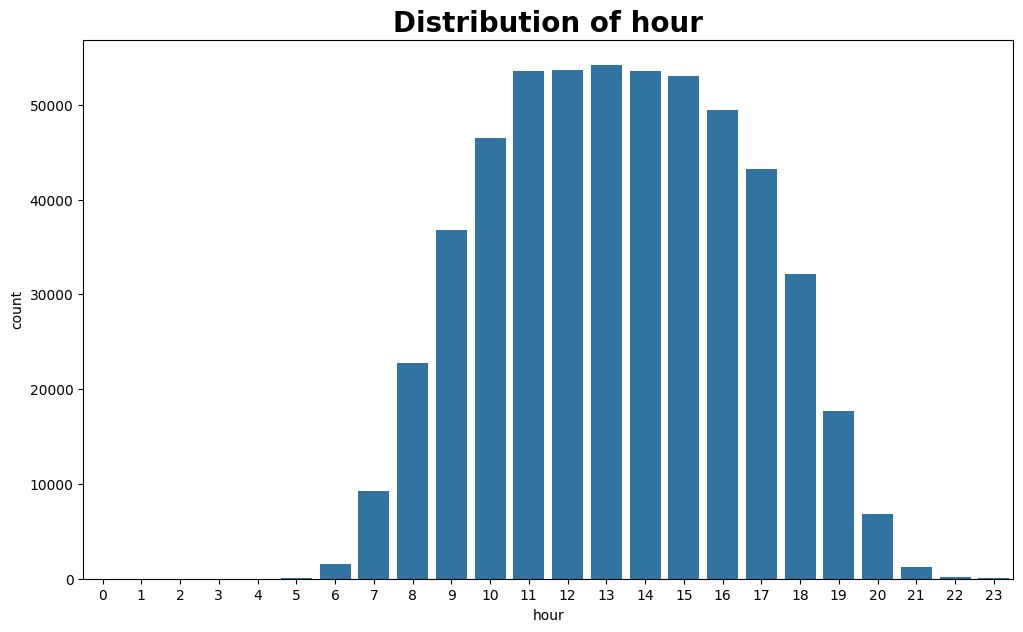

In [22]:
plot_count(completed_df, 'hour')

Get day of the week from datetime

In [11]:
from datetime import datetime

In [12]:
dt = datetime.now()
print('Datetime is:', dt)

print('day Name:', dt.strftime('%A'))

Datetime is: 2024-06-15 19:01:39.314958
day Name: Saturday


In [13]:
# Create weekend vs. weekday feature
completed_df['is_weekend'] = completed_df['datetime'].dt.weekday >= 5

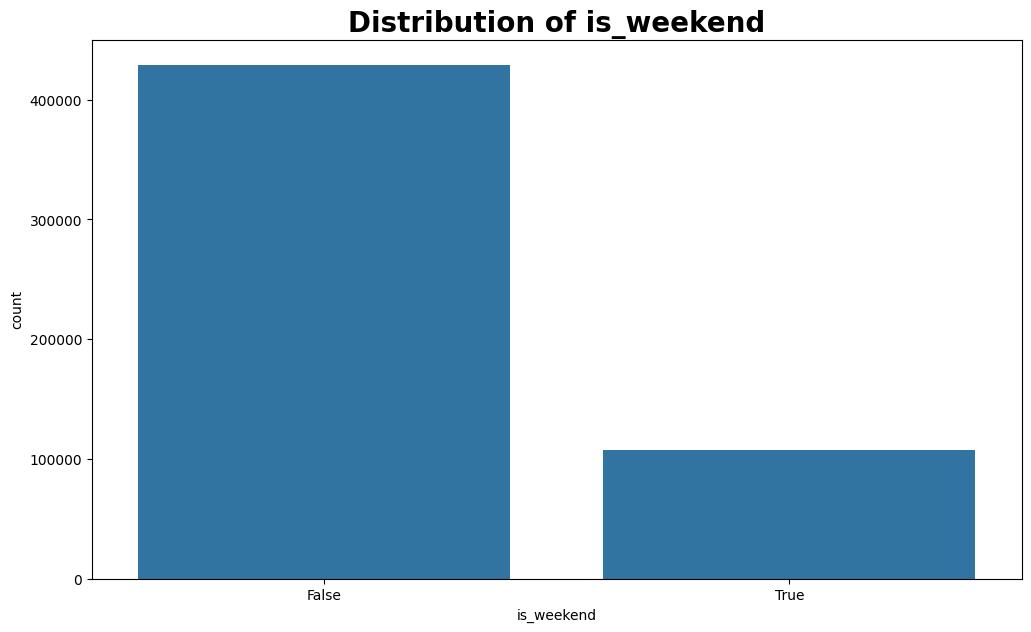

In [14]:
plot_count(completed_df, 'is_weekend')

Add holiday Feature

In [15]:
# Add holiday feature
nigeria_holidays = holidays.CountryHoliday('NG')

In [16]:
# Create a function to check for holidays
def is_holiday(date):
    return date in nigeria_holidays

In [19]:
completed_df['is_holiday'] = completed_df['datetime'].dt.date.apply(lambda x: x in nigeria_holidays)

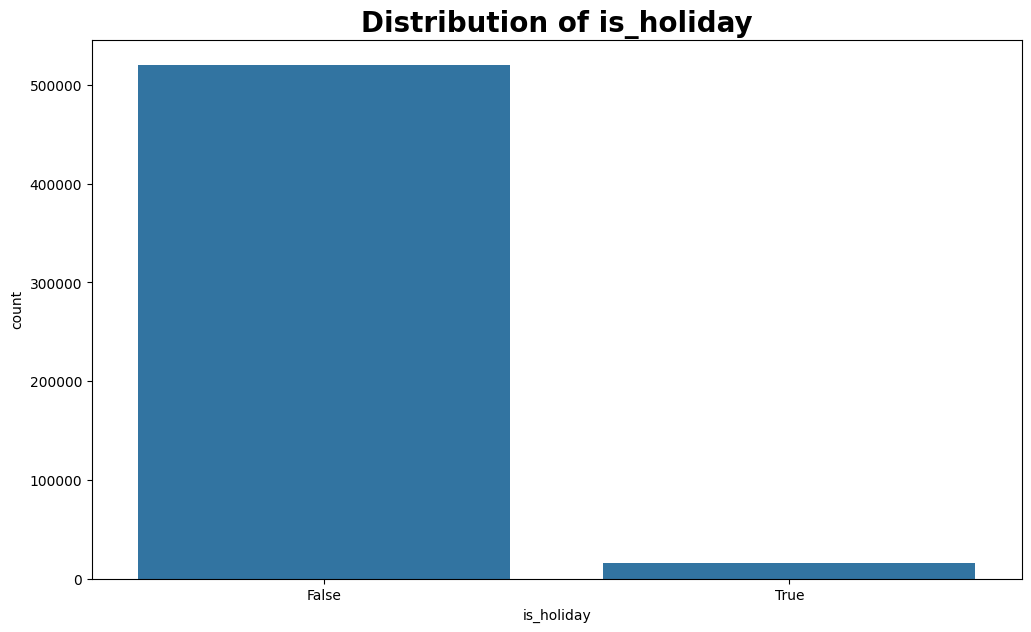

In [20]:
plot_count(completed_df, 'is_holiday')

In [ ]:
completed_df

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,datetime,hour,is_weekend
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37,2021-07-01 07:28:04,7,False
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28,2021-07-01 06:38:04,6,False
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23,2021-07-01 06:21:02,6,False
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42,2021-07-01 07:16:07,7,False
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False
...,...,...,...,...,...,...,...,...
536015,1637696,"6.448218499999999,3.4772075","6.437787399999999,3.481670199999999",2021-12-30 20:35:06,2021-12-30 21:02:59,2021-12-30 20:35:06,20,False
536016,1637702,"6.442320899999999,3.4736868","6.436589333407897,3.5559738188407835",2021-12-30 20:48:13,2021-12-30 21:43:49,2021-12-30 20:48:13,20,False
536017,1637704,"6.4281982,3.492248","6.448088500000001,3.4775747",2021-12-30 20:51:45,2021-12-30 21:41:32,2021-12-30 20:51:45,20,False
536018,1637705,"6.5869296,3.3632966","6.637906899999999,3.3339515",2021-12-30 20:48:50,2021-12-30 21:08:28,2021-12-30 20:48:50,20,False


In [ ]:
merged_df = pd.merge(completed_df, df, left_on='Trip ID', right_on='order_id')

In [ ]:
merged_df = merged_df.drop(['id', 'order_id'], axis=1)

In [ ]:
merged_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,datetime,hour,is_weekend,driver_id,driver_action,lat,lng
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,243828,accepted,6.602207,3.270465
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,243588,rejected,6.592097,3.287445
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,243830,rejected,6.596133,3.281784
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,243539,rejected,6.596142,3.280526
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,171653,rejected,6.609232,3.288800


In [ ]:
merged_df['driver_action'].unique()

array(['accepted', 'rejected'], dtype=object)

In [ ]:
merged_df['is_weekend'].unique()

array([False,  True])

In [ ]:
merged_df['Driver Location'] = merged_df.apply(lambda row: f"{row['lat']}, {row['lng']}", axis=1)

In [ ]:
merged_df['driver_clientdistance'] = merged_df.apply(lambda row: geodesic(
    (row['Driver Location']),
    (row['Trip Origin'])
).kilometers, axis=1)

In [ ]:
merged_df = merged_df.drop(['lat', 'lng'], axis=1)

In [ ]:
completed_df['Trip distance_km'] = completed_df.apply(lambda row: geodesic(
    (row['Trip Origin']),
    (row['Trip Destination'])
).kilometers, axis=1)

In [ ]:
completed_df['Trip End Time'] = pd.to_datetime(completed_df['Trip End Time'])
completed_df['duration_hours'] = completed_df.apply(lambda row: (row['Trip End Time'] - row['datetime']).total_seconds() / 3600, axis=1)

completed_df['speed_kmh'] = completed_df['Trip distance_km'] / completed_df['duration_hours']

In [ ]:
completed_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,datetime,hour,is_weekend,Trip distance_km,duration_hours,speed_kmh
0,391996,"6.508813001668548,3.37740316890347","6.650969799999999,3.3450307",2021-07-01 07:28:04,2021-07-01 07:29:37,2021-07-01 07:28:04,7,False,16.123451,0.025833,624.133590
1,391997,"6.4316714,3.4555375","6.4280814653326,3.4721885847586",2021-07-01 06:38:04,2021-07-01 07:07:28,2021-07-01 06:38:04,6,False,1.884305,0.490000,3.845521
2,391998,"6.631679399999999,3.3388976","6.508324099999999,3.3590397",2021-07-01 06:21:02,2021-07-01 07:02:23,2021-07-01 06:21:02,6,False,13.822393,0.689167,20.056676
3,391999,"6.572757200000001,3.3677082","6.584881099999999,3.3614073",2021-07-01 07:16:07,2021-07-01 07:29:42,2021-07-01 07:16:07,7,False,1.511034,0.226389,6.674507
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,20.984319,0.060278,348.126952


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 12 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Trip ID                1557740 non-null  int64         
 1   Trip Origin            1557740 non-null  object        
 2   Trip Destination       1557740 non-null  object        
 3   Trip Start Time        1555718 non-null  object        
 4   Trip End Time          1557740 non-null  object        
 5   datetime               1557740 non-null  datetime64[ns]
 6   hour                   1557740 non-null  int32         
 7   is_weekend             1557740 non-null  bool          
 8   driver_id              1557740 non-null  int64         
 9   driver_action          1557740 non-null  object        
 10  Driver Location        1557740 non-null  object        
 11  driver_clientdistance  1557740 non-null  float64       
dtypes: bool(1), datetime64[ns](1

In [ ]:
# Day of the week feature
merged_df['day_of_week'] = merged_df['datetime'].dt.strftime('%A')

In [ ]:
merged_df.head()

,Trip ID,Trip Origin,Trip Destination,Trip Start Time,Trip End Time,datetime,hour,is_weekend,driver_id,driver_action,Driver Location,driver_clientdistance,day_of_week
0,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,243828,accepted,"6.6022066, 3.2704649",0.694264,Thursday
1,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,243588,rejected,"6.5920972, 3.2874447",1.551694,Thursday
2,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,243830,rejected,"6.5961334, 3.2817841",0.786777,Thursday
3,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,243539,rejected,"6.5961416, 3.2805263",0.692054,Thursday
4,392001,"6.6010417,3.2766339","6.4501069,3.3916154",2021-07-01 09:30:59,2021-07-01 09:34:36,2021-07-01 09:30:59,9,False,171653,rejected,"6.6092317, 3.2887999",1.621848,Thursday


Rejections and accepted per day of the week

In [ ]:
rejected_df = merged_df[merged_df['driver_action'] == 'rejected']

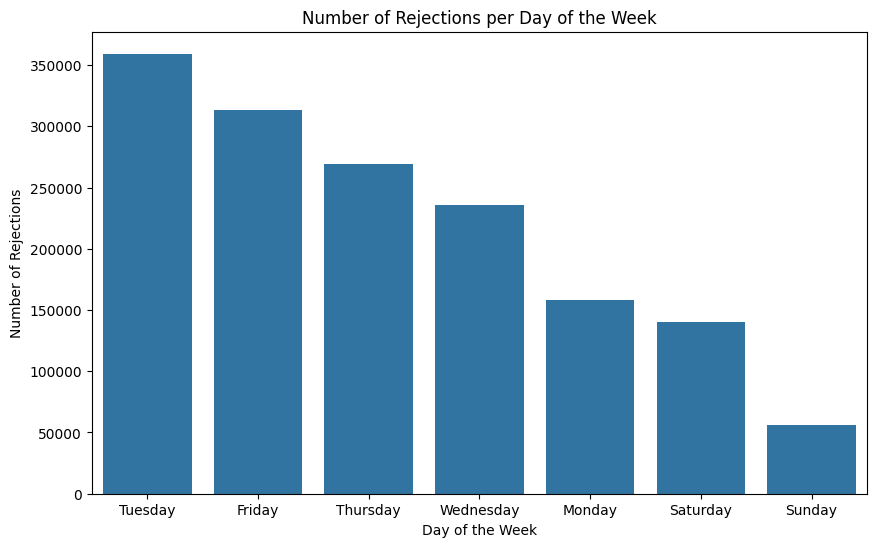

In [ ]:
# Sort the filtered data by day_of_week
sorted_rejected_df = rejected_df.sort_values(by='day_of_week')

# Plotting the number of rejections per day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=sorted_rejected_df, order=sorted_rejected_df['day_of_week'].value_counts().index)
plt.title('Number of Rejections per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rejections')
plt.show()

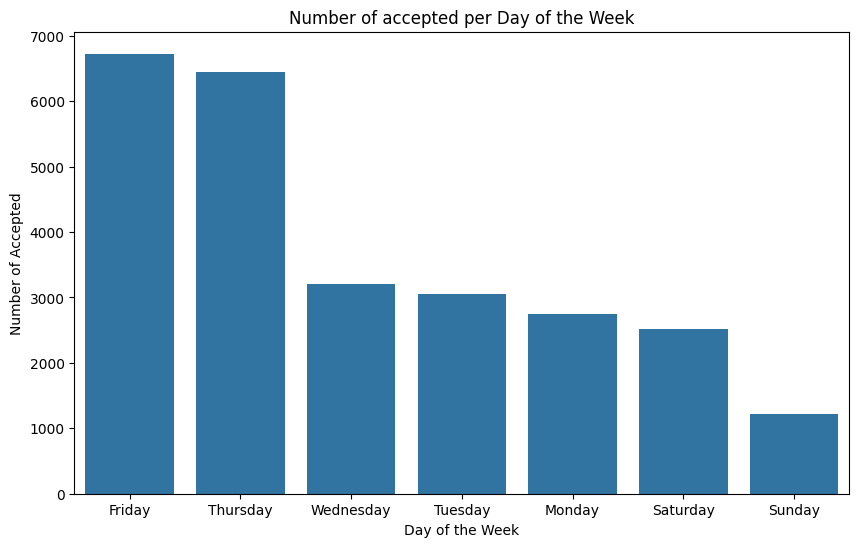

In [ ]:
accepted_df = merged_df[merged_df['driver_action'] == 'accepted']

# Sort the filtered data by day_of_week
sorted_df = accepted_df.sort_values(by='day_of_week')

# Plotting the number of rejections per day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=sorted_df, order=sorted_df['day_of_week'].value_counts().index)
plt.title('Number of accepted per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Accepted')
plt.show()

Top 10 drivers with most rejected and accepted

In [ ]:
rejected_df['driver_id'].value_counts().head(10)

driver_id
245538    6937
243020    6447
242971    6237
243676    5844
243932    5787
171165    5710
243581    5176
244121    4939
244031    4902
243826    4883
Name: count, dtype: int64

In [ ]:
accepted_df['driver_id'].value_counts().head(10)

driver_id
243296    69
245611    63
227856    60
244107    60
245649    59
243648    58
171149    58
243500    58
245587    57
243892    57
Name: count, dtype: int64

In [ ]:
merged_df['driver_id'].nunique()

1213

Driver_client distance

In [ ]:
# Detecting outliers using IQR
Q1 = merged_df['driver_clientdistance'].quantile(0.25)
Q3 = merged_df['driver_clientdistance'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_df = merged_df[(merged_df['driver_clientdistance'] >= lower_bound) & (merged_df['driver_clientdistance'] <= upper_bound)]

In [ ]:
distance_df = filtered_df.sort_values(by='driver_clientdistance', ascending=False)

In [ ]:
top_distance_df = distance_df.head(10)

top_distance_df[['driver_clientdistance', 'driver_action']]


,driver_clientdistance,driver_action
867509,4.417888,rejected
914254,4.417857,rejected
914264,4.417857,rejected
787882,4.417852,rejected
787909,4.417852,rejected
744926,4.417827,rejected
848158,4.417789,rejected
848207,4.417789,rejected
848272,4.417789,rejected
848101,4.417789,rejected


In [ ]:
bottom_distance_df = distance_df.tail(10)

bottom_distance_df[['driver_clientdistance', 'driver_action']]


,driver_clientdistance,driver_action
311314,0.0,accepted
167811,0.0,accepted
52946,0.0,accepted
1555016,0.0,accepted
637375,0.0,accepted
534633,0.0,accepted
1053064,0.0,accepted
415869,0.0,accepted
33739,0.0,accepted
585557,0.0,accepted


In [ ]:
import os
from dotenv import load_dotenv

In [ ]:
api_key = os.getenv("WEATHER_API_KEY")

In [ ]:
# Function to get weather data
def get_weather(lat, lon, date):
    try:
        url = "https://archive-api.open-meteo.com/v1/archive"
        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': date,
            'end_date': date,
            'hourly': 'precipitation',
            'timezone': 'UTC'
        }
        response = requests.get(url, params=params)
        data = response.json()

        # Check if the response contains precipitation data
        if 'hourly' in data and 'precipitation' in data['hourly']:
            return data['hourly']['precipitation'][0]  # Return the first hour's precipitation data as an example
        return None
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return None

In [ ]:
# Extract latitude and longitude from 'Driver Location'
merged_df[['lat', 'lon']] = merged_df['Driver Location'].str.split(',', expand=True)
merged_df['lat'] = merged_df['lat'].astype(float)
merged_df['lon'] = merged_df['lon'].astype(float)

In [ ]:
merged_df['date'] = merged_df['datetime'].dt.date

In [ ]:
# Save the DataFrame to a CSV file after EDA
output_csv_path = '../data/processeddata/completedrequests.csv'
completed_df.to_csv(output_csv_path, index=False)

In [ ]:
completed_df.columns

Index(['Trip ID', 'Trip Origin', 'Trip Destination', 'Trip Start Time',
       'Trip End Time', 'datetime', 'hour', 'is_weekend', 'Trip distance_km',
       'duration_hours', 'speed_kmh'],
      dtype='object')

In [ ]:
# Save the DataFrame to a CSV file after EDA
output_csv_path = '../data/processeddata/mergeddata.csv'
merged_df.to_csv(output_csv_path, index=False)